In [5]:
import os
import numpy as np
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from google.colab import drive

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

images = np.concatenate((train_images, test_images), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

images = images / 255.0
labels = labels.astype(np.int32)

In [7]:
def baseline_model():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(784, activation='relu', kernel_initializer='normal'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer='normal'),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax', kernel_initializer='normal')
        ])
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
        )

    return model


X_train, X_test, y_train, y_test = \
    train_test_split(images, labels, test_size=0.1, random_state=10, stratify=labels)

tf.data.Dataset.from_tensor_slices((X_train, y_train))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [8]:
model = baseline_model()
model.fit(X_train, y_train, batch_size=64, validation_split=0.2, epochs=30, verbose=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Accuracy on test data: {test_acc}')

Epoch 1/30
788/788 [==============================] - 16s 19ms/step - loss: 0.5424 - accuracy: 0.8056 - val_loss: 0.4093 - val_accuracy: 0.8524
Epoch 2/30
788/788 [==============================] - 16s 20ms/step - loss: 0.4015 - accuracy: 0.8537 - val_loss: 0.3893 - val_accuracy: 0.8544
Epoch 3/30
788/788 [==============================] - 15s 19ms/step - loss: 0.3648 - accuracy: 0.8654 - val_loss: 0.3560 - val_accuracy: 0.8658
Epoch 4/30
788/788 [==============================] - 15s 19ms/step - loss: 0.3440 - accuracy: 0.8729 - val_loss: 0.3494 - val_accuracy: 0.8707
Epoch 5/30
788/788 [==============================] - 15s 18ms/step - loss: 0.3260 - accuracy: 0.8809 - val_loss: 0.3326 - val_accuracy: 0.8795
Epoch 6/30
788/788 [==============================] - 17s 21ms/step - loss: 0.3127 - accuracy: 0.8831 - val_loss: 0.3271 - val_accuracy: 0.8792
Epoch 7/30
788/788 [==============================] - 15s 19ms/step - loss: 0.3014 - accuracy: 0.8887 - val_loss: 0.3270 - val_accuracy:

In [9]:
drive.mount('/content/gdrive')

model.save('/content/gdrive/MyDrive/modul18_3/model.keras')

Mounted at /content/gdrive


In [10]:
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/modul18_3/model.keras')

1/1 [==============================] - 0s 130ms/step


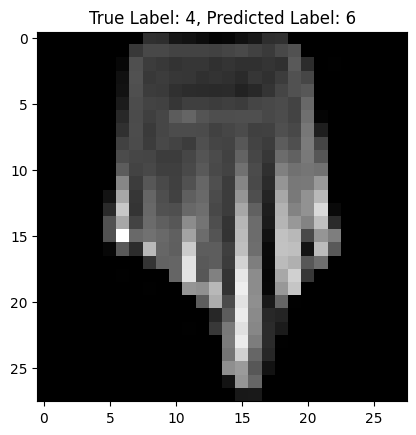

1/1 [==============================] - 0s 22ms/step


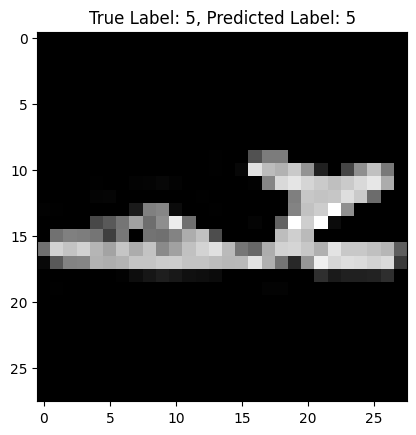

1/1 [==============================] - 0s 23ms/step


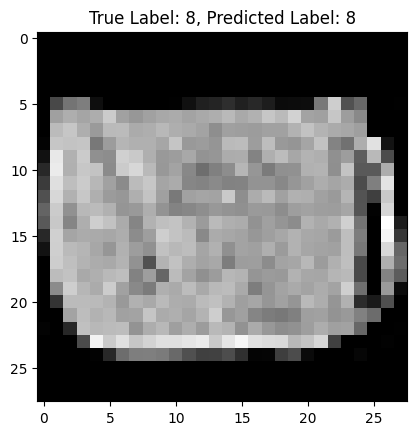

In [11]:
# Funkcja do przewidywania i wyświetlania obrazu
def predict_and_display(index):
    input_image = X_test[index]
    true_label = y_test[index]

    input_image = np.expand_dims(input_image, axis=0)

    predicted_label = np.argmax(model.predict(input_image))

    plt.imshow(X_test[index], cmap='gray')
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()


predict_and_display(0)
predict_and_display(1)
predict_and_display(2)

In [15]:
# Funkcja do konwersji i augmentacji obrazów
def augment_images(images, labels, n_repeats=2):
    augmented_images = []
    augmented_labels = []
    transform = A.Compose([
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.Blur(blur_limit=9, p=0.5),
        ], p=1.0),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.8, contrast_limit=0.8, p=0.5)
    ])

    for image, label in zip(images, labels):
        image = (image * 255).astype(np.uint8)

        for _ in range(n_repeats):
            augmented = transform(image=image)
            augmented_images.append(augmented['image'])
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)


augmented_X_train, augmented_y_train = augment_images(X_train, y_train)

X_train_augmented = np.concatenate((X_train, augmented_X_train), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_y_train), axis=0)

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=42)

In [16]:
len(X_train_augmented)

189000

In [21]:
model_v2 = baseline_model()
model_v2.fit(X_train_augmented, y_train_augmented, batch_size=128, validation_split=0.2, epochs=30, verbose=1)
test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test, y_test)
print(f'Accuracy on test data: {test_acc_v2}')

Epoch 1/30
1182/1182 [==============================] - 32s 26ms/step - loss: 2.3113 - accuracy: 0.2904 - val_loss: 1.5975 - val_accuracy: 0.4021
Epoch 2/30
1182/1182 [==============================] - 28s 24ms/step - loss: 1.4913 - accuracy: 0.4563 - val_loss: 1.1550 - val_accuracy: 0.5407
Epoch 3/30
1182/1182 [==============================] - 29s 24ms/step - loss: 1.1987 - accuracy: 0.5542 - val_loss: 0.9612 - val_accuracy: 0.6379
Epoch 4/30
1182/1182 [==============================] - 30s 26ms/step - loss: 1.0877 - accuracy: 0.5941 - val_loss: 0.9186 - val_accuracy: 0.6438
Epoch 5/30
1182/1182 [==============================] - 29s 24ms/step - loss: 1.0828 - accuracy: 0.5952 - val_loss: 0.8533 - val_accuracy: 0.6787
Epoch 6/30
1182/1182 [==============================] - 29s 24ms/step - loss: 0.9844 - accuracy: 0.6233 - val_loss: 0.8212 - val_accuracy: 0.6841
Epoch 7/30
1182/1182 [==============================] - 27s 23ms/step - loss: 0.9765 - accuracy: 0.6312 - val_loss: 0.8104 -